# Game Sales
Luke Tao (lyt5), Euna Lee (ekl49), Vinny Huang (vh222)


----
# Introduction
This project aims to determine what number of global sales a game will reach given certain information about the game (publisher, genre, metascore, etc.).

**Hypothesis**:
The publisher, genre, metascore, and userscore will be the features that best predict the global sales of a game.

# Sources
We three datasets in our analysis. The first was the primary dataset which provided sales information along with platform, year, genre, and publisher. We used two supplementary datasets to provide metacritic scores. 

The datasets are public domain and hosted by Kaggle.com

sales: https://www.kaggle.com/datasets/ulrikthygepedersen/video-games-sales

scores 1: https://www.kaggle.com/datasets/deepcontractor/top-video-games-19952021-metacritic

scores 2: https://www.kaggle.com/datasets/henrylin03/metacritic-games-user-reviews-and-metascores

----

In [140]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

# load data
sales = pd.read_csv('video_games_sales.csv')
scores = pd.read_csv('top_video_games.csv', skipinitialspace=True)
scores2 = pd.read_csv('metacritic.csv', skipinitialspace=True)

sales = sales.convert_dtypes()
scores = scores.convert_dtypes()
scores2 = scores2.convert_dtypes()

# remove unecesssary/duplicate columns
sales.drop(['rank'], inplace=True, axis=1)
scores.drop(['release_date', 'summary'], inplace=True, axis=1)
scores2.drop(['release_date', 'summary'], inplace=True, axis=1)

sales.head()

,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.0
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.0,31.37


# Merging Files
Now that we have imported all of the datasets and removed duplicate columns, we now need to combine them all into one dataframe.

In [141]:
# Metacritic score datasets use different platform names than sales dataset
platform_dict = {  
  'PC' : 'PC',
  'Nintendo 64' : 'N64',
  'GameCube' : 'GC',
  'Game Boy' : 'GB',
  'Game Boy Color' : 'GBC',
  'Game Boy Advance' : 'GBA',
  'Switch' : 'Switch',
  'Stadia' : 'Stadia',
  'DS' : 'DS',
  '3DS' : '3DS',
  'Wii' : 'Wii',
  'Wii U' : 'WiiU',
  'PSP' : 'PSP',
  'PlayStation Vita' : 'PSV',
  'PlayStation' : 'PS',
  'PlayStation 2' : 'PS2',
  'PlayStation 3' : 'PS3', 
  'PlayStation 4' : 'PS4', 
  'PlayStation 5' : 'PS5', 
  'Dreamcast' : 'DC', 
  'Xbox' : 'XB', 
  'Xbox 360' : 'X360', 
  'Xbox One' : 'XOne',
  'Xbox Series X' : 'XSX'
}

In [142]:
# add scores to sales
scores['platform'] = scores['platform'].map(platform_dict).fillna(scores['platform'])
scores = scores.replace(to_replace='tbd', value=pd.NA)
scores = scores.rename(columns={'user_review': 'userscore',
                   'meta_score': 'metascore'}, errors='raise')
scores['userscore'] = scores['userscore'].astype('Float64')

df = pd.merge(sales, scores, on=['name', 'platform'], how='left')
df = df.sort_values(['name', 'platform'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16635 entries, 4760 to 9155
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16635 non-null  string 
 1   platform      16635 non-null  object 
 2   year          16363 non-null  Int64  
 3   genre         16635 non-null  string 
 4   publisher     16577 non-null  string 
 5   na_sales      16635 non-null  Float64
 6   eu_sales      16635 non-null  Float64
 7   jp_sales      16635 non-null  Float64
 8   other_sales   16635 non-null  Float64
 9   global_sales  16635 non-null  Float64
 10  metascore     6172 non-null   Int64  
 11  userscore     5815 non-null   Float64
dtypes: Float64(6), Int64(2), object(1), string(3)
memory usage: 1.8+ MB


,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,metascore,userscore
4760,'98 Koshien,PS,1998,Sports,Magical Company,0.15,0.1,0.12,0.03,0.41,<NA>,<NA>
8375,.hack//G.U. Vol.1//Rebirth,PS2,2006,Role-Playing,Namco Bandai Games,0.0,0.0,0.17,0.0,0.17,<NA>,<NA>
7123,.hack//G.U. Vol.2//Reminisce,PS2,2006,Role-Playing,Namco Bandai Games,0.11,0.09,0.0,0.03,0.23,<NA>,<NA>
8620,.hack//G.U. Vol.2//Reminisce (jp sales),PS2,2006,Role-Playing,Namco Bandai Games,0.0,0.0,0.16,0.0,0.16,<NA>,<NA>
8322,.hack//G.U. Vol.3//Redemption,PS2,2007,Role-Playing,Namco Bandai Games,0.0,0.0,0.17,0.0,0.17,<NA>,<NA>


In [143]:
# add scores2 to dataframe
scores2['platform'] = scores2['platform'].map(platform_dict).fillna(scores2['platform'])
scores2 = scores2.replace(to_replace='tbd', value=pd.NA)
scores2['metascore'] = scores2['metascore'].astype('Int64')
scores2['userscore'] = scores2['userscore'].astype('Float64')
scores2 = scores2.sort_values(['name', 'platform'])

df = df.sort_values(['name', 'platform'])
df.update(scores2, join='left')
df['metascore'] = df['metascore'].astype('Int64')
df['userscore'] = df['userscore'].astype('Float64')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16635 entries, 4760 to 9155
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16635 non-null  object 
 1   platform      16635 non-null  object 
 2   year          16363 non-null  Int64  
 3   genre         16635 non-null  string 
 4   publisher     16577 non-null  string 
 5   na_sales      16635 non-null  Float64
 6   eu_sales      16635 non-null  Float64
 7   jp_sales      16635 non-null  Float64
 8   other_sales   16635 non-null  Float64
 9   global_sales  16635 non-null  Float64
 10  metascore     8228 non-null   Int64  
 11  userscore     8607 non-null   Float64
dtypes: Float64(6), Int64(2), object(2), string(2)
memory usage: 1.8+ MB


,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,metascore,userscore
4760,Airport Madness 3D,PC,1998,Sports,Magical Company,0.15,0.1,0.12,0.03,0.41,<NA>,<NA>
8375,Arena Football,PS2,2006,Role-Playing,Namco Bandai Games,0.0,0.0,0.17,0.0,0.17,66,8.1
7123,Antihero: Armello Character Pack,PC,2006,Role-Playing,Namco Bandai Games,0.11,0.09,0.0,0.03,0.23,<NA>,<NA>
8620,Armored Core 3,PS2,2006,Role-Playing,Namco Bandai Games,0.0,0.0,0.16,0.0,0.16,74,8.7
8322,Are You Smarter Than A 5th Grader?,PS4,2007,Role-Playing,Namco Bandai Games,0.0,0.0,0.17,0.0,0.17,<NA>,<NA>


In [144]:
df['publisher'] = df['publisher'].fillna("Unknown")
df = df.convert_dtypes()
print(df.isna().sum())
df = df.loc[(df['metascore'] != "<NA>") & (df['userscore'] != "<NA>") &(df['global_sales'] != float('NaN')) & (df['publisher'] != "Unknown") & (df['genre'] != "Misc")]

name               0
platform           0
year             272
genre              0
publisher          0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
global_sales       0
metascore       8407
userscore       8028
dtype: int64


----
# Data Visualization
Now that we have successfully combined and cleaned the data, we can now start gaining a better understanding of its trends and features.

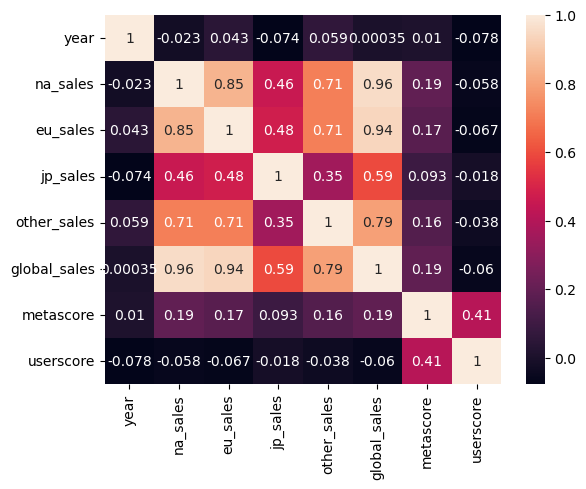

In [145]:
sns.heatmap(df.corr(), annot =True )
plt.show()

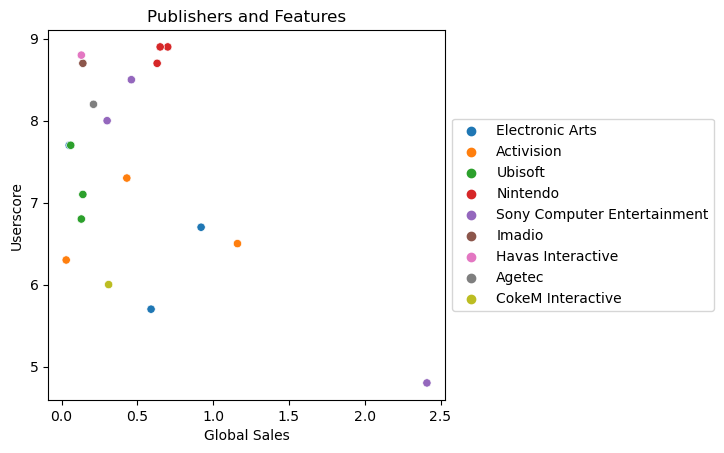

<Figure size 640x480 with 0 Axes>

In [201]:
# # Take 5 well-known publishers and 5 unknown publishers
popular = df['publisher'].value_counts().nlargest(5)
non_popular = df['publisher'].value_counts().nsmallest(5)

p = df.loc[(df['publisher'] == "Electronic Arts")]
p1 = p.head(3)
p = df.loc[(df['publisher'] == "Activision")]
p2 = p.head(3)
p = df.loc[(df['publisher'] == "Ubisoft")]
p3 = p.head(3)
p = df.loc[(df['publisher'] == "Nintendo")]
p4 = p.head(3)
p = df.loc[(df['publisher'] == "Sony Computer Entertainment")]
p5 = p.head(3)

p = [p1,p2,p3,p4,p5]
popular = pd.concat(p)

non_popular = df.loc[(df['publisher'] == "CokeM Interactive") | (df['publisher'] == "Imadio") | (df['publisher'] == "Havas Interactive") | (df['publisher'] == "Agetec") | (df['publisher'] == "Tru Blue Entertainment")]

p = [popular,non_popular]
publishers = pd.concat(p)

ax = sns.scatterplot(x = publishers['global_sales'], y = publishers['userscore'], hue = publishers['publisher'])
plt.title('Publishers and Features')
plt.xlabel('Global Sales')
plt.ylabel('Userscore')

fig = plt.figure()

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

----
# Machine Learning (Testing Hypothesis)

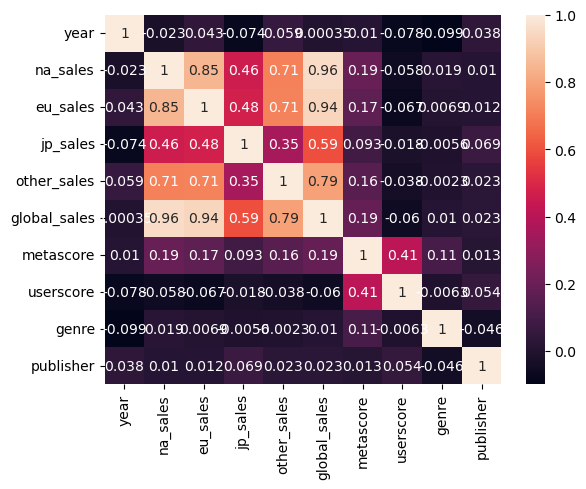

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() # creating label encoder instance

genreLabel = le.fit_transform(df['genre']) # .fit_transform function fits labels

df.drop('genre',axis=1,inplace=True) # dropping the categorical data
df['genre'] = genreLabel # setting the categorical data values into numerical data values

publisherLabel = le.fit_transform(df['publisher']) # doing same thing with publishers

df.drop('publisher',axis=1,inplace=True)
df['publisher'] = publisherLabel

sns.heatmap(df.corr(), annot =True )
plt.show()


In [14]:
feature = df[['genre','publisher','metascore','userscore']]
target = df['global_sales'] 

feature_train,feature_test,target_train,target_test = train_test_split(feature,target,test_size = 0.2,random_state = 42)

model = LinearRegression()

model.fit(feature_train,target_train)
prediction = model.predict(feature_test)

print('Model training score: ', model.score(feature_train, target_train))
print('Model testing score: ', model.score(feature_test, target_test))

Model training score:  0.05330584760026724
Model testing score:  0.10423009222442092


/Users/vinny/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/Users/vinny/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:95: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)


----
# Analysis Thus Far

After running a linear regression to try and predict global sales numbers of a game given their genre, publisher, metascore, and userscore, we were surprised to find out that the aforementioned features were not all that good in predicting global sales; this was reflected in the correlation matrix after we converted categorical data like genre and publisher into numerical data via labels. At a first glance, we thought that there would surely be a correlation between how good a game is (though admittedly through subjective standards such as metascore and userscore) and how well the game would do in the market, but through the linear regression test, we can see that other factors not captured in the dataset we are working with affect global sales. 

One factor that we thought of after looking back on our data and test is the budget of the game. Although we made sure to include the publisher as a feature for our model, we naively neglected the fact that not all games by the same publisher are treated equally. What we mean by this is that some games which have historically brought in more profit are more likely to receive more money when it comes time to create a sequel to the game. A larger budget would enable game developers to spend more time and effort into the game, making it better and potentially making it more popular world wide on release. We have looked into datasets that include this feature, but unfortunately, we have not found one. Going forward, this is a feature that we would like to see play a role into our model, and whether or not it might positively or negatively impact our model's accuracy.

Another factor to consider is the popularity of a publisher. As seen in the scatterplot above, more well-known publishers such as Sony having a much higher global sales but lower userscore than other games made by different publishers. This can be explained by new variables such as marketing and customer bias that isn't considered in these data sets creating unexpected values. In this situation, the reason this game has had much higher global sales than all the other games could be due to good marketing and how popular the Sony's previous games were. However, the low userscore could be due to customer bias as they would have high expectations that the game failed to meet.

Moving on, we want to explore the features that DO best predict global sales. Looking back at our correlation matrix, we want to test na_sales and eu_sales as features, and see how our linear regression model changes.

# Machine Learning (Testing Other Avenues)

In [58]:
feature = df[['na_sales','eu_sales']]
target = df['global_sales'] 

feature_train,feature_test,target_train,target_test = train_test_split(feature,target,test_size = 0.2,random_state = 42)

model = LinearRegression()

model.fit(feature_train,target_train)
prediction = model.predict(feature_test)

print('Model training score: ', model.score(feature_train, target_train))
print('Model testing score: ', model.score(feature_test, target_test))

Model training score:  0.9725377304205741
Model testing score:  0.9777352759229455


/Users/eunalee/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(
/Users/eunalee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/Users/eunalee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to nume